In [113]:
import pandas as pd 

import numpy as np 
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.api import types

from linearmodels import PanelOLS


In [114]:
data = pd.read_csv("src/did_training_productivity.csv", index_col = 0)

Estimate the simple 2x2 Difference-in-Differences (DiD) model without covariates:

$$ Y_{it} = \alpha + \beta W_i + \gamma \text{Post}_t + \theta (W_i \times \text{Post}_t) + \epsilon_{it} $$

Report results for both the extensive margin treatment and intensive margin (replace treatment indicator with hours).

In [115]:
# extensive margin_treatment
data22_extensive = data.copy()
data22_extensive["interaction_post"] = data22_extensive["post"]*data22_extensive["treat_group"]

y = data22_extensive["productivity"]
X_extensive = data22_extensive[["treat_group","post", "interaction_post"]]

did22_extensive = sm.OLS(y, sm.add_constant(X_extensive)).fit()

In [116]:
did22_extensive.get_robustcov_results(cov_type = "cluster", groups = data22_extensive.index).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           productivity   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 1.706e+04
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:04:29   Log-Likelihood:            -2.1204e+05
No. Observations:               48000   AIC:                         4.241e+05
Df Residuals:                   47996   BIC:                         4.241e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              126.5662      0.438    289.055      0.000     125.708     127.425
treat_group          2.8069      0.819      3.427      0.001       1.201       4.413
post                13.0608      0.113    115.908      0.000      12.840      13.282
interaction_post    22.4094      0.216    103.703      0.000      21.986      22.833
==============================================================================
Omnibus:                        7.125   Durbin-Watson:                   0.679
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.108
Skew:                          -0.025   Prob(JB):                       0.0286
Kurtosis:                       2.969   Cond. No.                         6.35
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

The number of hours that a worker is treated changes over time. In order to do exercise 3 (part II) of the pset, you need to average those hours across all the years in which worker i got training, and use that as your time-invariant treatment intensity. (Obviously, you nee to assign this figure also to the years prior to treatment, so that it can be interacted with the Post dummy in the estimating equation)

In [132]:
data22_intensive = data.copy()
data22_intensive["interaction_hours"] = data22_intensive["post"]*data22_intensive["treat_hours"]

data22_intensive["avg_hours"] = 0
data22_intensive["avg_hours"] = data22_intensive["avg_hours"].astype(float)

for worker_id in range(1,2001):
    data22_intensive.loc[data22_intensive.index == worker_id, "avg_hours"] = data22_intensive.groupby(level= 0)["treat_hours"].mean().astype(float)

y_intensive =data22_intensive["productivity"]
X_intensive = data22_intensive[["avg_hours","post", "interaction_hours"]]

In [133]:
did22_intensive = sm.OLS(y, sm.add_constant(X_intensive)).fit()

In [134]:
did22_intensive.get_robustcov_results(cov_type = "cluster", groups = data22_intensive.index).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           productivity   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 1.629e+04
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:10:29   Log-Likelihood:            -2.1212e+05
No. Observations:               48000   AIC:                         4.242e+05
Df Residuals:                   47996   BIC:                         4.243e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               126.2861      0.438    288.572      0.000     125.428     127.144
avg_hours             0.3759      0.082      4.581      0.000       0.215       0.537
post                 13.6372      0.115    118.883      0.000      13.412      13.862
interaction_hours     1.0288      0.010     98.774      0.000       1.008       1.049
==============================================================================
Omnibus:                        6.742   Durbin-Watson:                   0.682
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.740
Skew:                          -0.026   Prob(JB):                       0.0344
Kurtosis:                       2.972   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

Estimate the two-way fixed effects model:

$$ Y_{it} = \alpha_i + \delta_t + \theta (W_i \times \text{Post}_t) + \epsilon_{it} $$

Compare results with the simple DiD.

In [120]:
fe_2way_data = data22_extensive.reset_index().copy()

fe_2way_data = fe_2way_data.set_index(["worker_id", "period"])

y_2way = fe_2way_data["productivity"]
X_2way = fe_2way_data["interaction_post"]

In [121]:
entity_ids = pd.Series(y_2way.index.get_level_values(0))
fe_model = PanelOLS(y_2way, X_2way, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)

In [122]:
fe_model

Dep. Variable:,productivity,R-squared:,0.1912
Estimator:,PanelOLS,R-squared (Between):,0.0496
No. Observations:,48000,R-squared (Within):,0.3152
Date:,"Thu, Apr 17 2025",R-squared (Overall):,0.0531
Time:,20:04:40,Log-likelihood,-1.812e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.087e+04
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,45976)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,1.031e+04


Conduct randomization inference:

(a) Randomly reassign treatment status 500 times

(b) Estimate the placebo treatment effect each time

(c) Compare your actual estimate to this distribution

(d) Calculate the p-value as the proportion of placebo effects larger
in absolute value than your estimate

In [123]:
def randomization_inference_extensive(df:pd.DataFrame, treat_col:str, n:int, n_treatments: int, confidence_level: int):

    num_permutations = n

    df_ri = df.copy()
    df_ri = df_ri.drop([treat_col], axis = 1)

    unique_indices = df_ri.index.unique()

    intpost_coefficients = []
    
    for i in range(num_permutations):
        permuted_df = df_ri.copy()

        # I randomly choose to which workers to assign the treatment status
        treated_indices = np.random.choice(unique_indices, size=n_treatments, replace=False)

        permuted_df["treatment"] = 0
        permuted_df.loc[permuted_df.index.isin(treated_indices), "treatment"] = 1

        permuted_df["interaction_post"] = permuted_df["post"]*permuted_df["treatment"]
        
        X_ri = permuted_df[["treatment","post", "interaction_post"]]
        y_ri = permuted_df["productivity"]

        reg = sm.OLS(y_ri, sm.add_constant(X_ri)).fit(cov_type="cluster", cov_kwds={'groups': permuted_df.index})
        
        intpost_coefficient = reg.params['interaction_post']
        intpost_coefficients.append(intpost_coefficient)
    
    return (np.percentile(intpost_coefficients, confidence_level),np.percentile(intpost_coefficients, 100-confidence_level)), intpost_coefficients

In [124]:
treated_workers = int(data22_extensive.groupby(level = 0)["treat_group"].mean().sum())

In [126]:
ri_extensive, extensive_array =  randomization_inference_extensive(data22_extensive, treat_col= "treat_group", n = 500, n_treatments= treated_workers, confidence_level= 5)
ri_extensive

(-0.8383161923720307, 0.8305027438036977)

In [127]:
coeff_extensive = did22_extensive.params["interaction_post"]

t_statistic, p_value_two_sided = stats.ttest_1samp(extensive_array, coeff_extensive, alternative='two-sided')
print(p_value_two_sided)

0.0


In [129]:
def randomization_inference_intensive(df:pd.DataFrame, treat_col:str, n:int, n_treatments: int, confidence_level: int):

    num_permutations = n
    df_ri = df.copy()

    unique_indices = df_ri.index.unique()

    original_treated_workers_data = df[df[treat_col] == 1]
    unique_avg_treated_hours = original_treated_workers_data.groupby(level=0)["avg_hours"].first().values

    intpost_coefficients = []

    for i in range(num_permutations):
            permuted_df = df_ri.copy()
            permuted_df["treated"] = 0
            permuted_df["treated_hours_permuted"] = 0.0  # Initialize treated hours

            treated_worker_ids = np.random.choice(unique_indices, size=n_treatments, replace=False)

            treated_hours_random = np.random.choice(unique_avg_treated_hours, size=n_treatments, replace=False)

            # Randomly assign average treated hours to the selected workers
            for index,worker_id in enumerate(treated_worker_ids):
                    permuted_df.loc[permuted_df.index == worker_id, 'treated_hours_permuted'] = treated_hours_random[index]

            permuted_df["interaction_post"] = permuted_df["post"] * permuted_df["treated_hours_permuted"]

            X_ri = permuted_df[["treated_hours_permuted", "post", "interaction_post"]]
            y_ri = permuted_df["productivity"]

            reg = sm.OLS(y_ri, sm.add_constant(X_ri)).fit(cov_type="cluster", cov_kwds={'groups': permuted_df.index.get_level_values(0)})

            intpost_coefficient = reg.params['interaction_post']
            intpost_coefficients.append(intpost_coefficient)

    return (np.percentile(intpost_coefficients, confidence_level), np.percentile(intpost_coefficients, 100 - confidence_level)), intpost_coefficients

In [130]:
ri_intensive, intensive_array =  randomization_inference_intensive(data22_intensive, treat_col= "treat_group", n = 500, n_treatments= treated_workers, confidence_level= 5)
ri_extensive

(-0.8383161923720307, 0.8305027438036977)

In [136]:
coeff_intensive = did22_intensive.params["interaction_hours"]

t_statistic, p_value_two_sided = stats.ttest_1samp(intensive_array, coeff_intensive, alternative='two-sided')
print(p_value_two_sided)

0.0


In [137]:
def randomization_inference_fe(df:pd.DataFrame, treat_col:str, n:int, n_treatments: int, confidence_level: int):

    num_permutations = n

    df_ri = df.copy()
    df_ri = df_ri.drop([treat_col], axis = 1)

    unique_indices = df_ri.index.unique()

    intpost_coefficients = []
    
    for i in range(num_permutations):
        permuted_df = df_ri.reset_index().copy()

        treated_indices = np.random.choice(unique_indices, size=n_treatments, replace=False)

        permuted_df["treatment"] = 0
        permuted_df.loc[permuted_df.index.isin(treated_indices), "treatment"] = 1

        permuted_df["interaction_post"] = permuted_df["post"]*permuted_df["treatment"]

        permuted_df = permuted_df.set_index(["worker_id", "period"])

        y_2way = permuted_df["productivity"]
        X_2way = permuted_df["interaction_post"]

        ####
        fe_model = PanelOLS(y_2way, X_2way, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)
        ####

        intpost_coefficient = fe_model.params['interaction_post']
        intpost_coefficients.append(intpost_coefficient)
        
    
    return (np.percentile(intpost_coefficients, confidence_level),np.percentile(intpost_coefficients, 100-confidence_level)), intpost_coefficients

In [138]:
# weird results with this; to check again
ri_fe, coefficients = randomization_inference_fe(data22_extensive, "treat_group", 500, treated_workers, 5)
ri_fe

(-2.5516372740402273, -0.08868773850024038)

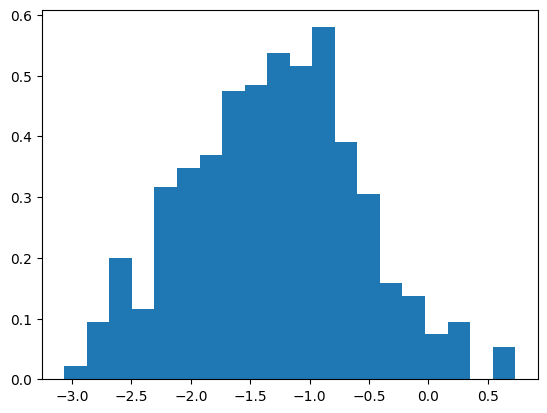

In [139]:
plt.hist(coefficients, density= True, bins = 20);

In [141]:
coeff_fe = fe_model.params["interaction_post"]

t_statistic, p_value_two_sided = stats.ttest_1samp(coefficients, coeff_fe, alternative='two-sided')
print(p_value_two_sided)

0.0
